<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Study an integral

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from task_7_test import integrate, f, g
from mpi4py import MPI

**(1) Compute the value analytically**

$S = \displaystyle \int_a^b \displaystyle x^4 \, dx$ , where $a = -3$ and $b = 3$

Provide a parallel numerical computation of the integral $S$ using, for example, the trapezoidal approximation $\displaystyle \int_{a}^{b} f(x) \approx S_D = \displaystyle \sum_{k = 1}^{N-1} \displaystyle \frac{f\left(a + k \,\tau\right)+ f\left(a + \left(k - 1\right) \tau\right) }{2}\,\,\tau$, where $ a + (N - 1)\tau = b$
Analytical expression $S = \frac{x^5}{5} |_a^b$

Suppose we set the limits of integration to $a = -3$ and $b = 3$. Then $S = \frac{x^5}{5} |_{-3}^3 = 97.2$

**(2) Compute the integral using trapezoidal rule**

In [ ]:
D_range = np.linspace(10, 10000, num=1000)
limits = [-3, 3]
S = g(limits[1]) - g(limits[0]) # exact value
err = []
for D in D_range:
    dd = int(D)
    S_d = integrate(f, limits=limits, num_steps=dd)
    err.append(S - S_d)

In [ ]:
S_d

97.19030591676032

**(5) Plot integration error vs the discretization size**

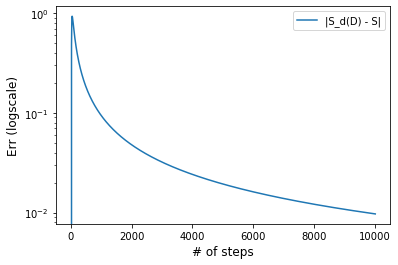

In [ ]:
plt.semilogy(D_range, err, label="|S_d(D) - S|")   
plt.xlabel("# of steps", fontsize=12)
plt.ylabel("Err (logscale)", fontsize=12)
plt.legend()

**(3) Parallelize using MPI. You should be able to choose any number of MPI processes regardless of the number of discretization points**

In [ ]:
time_arr = []
for i in range(1, 7):
    print(f'{i} process(es)\n\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_7_test.py
    time_arr.append(t.best)

1 process(es)
	277 ms ± 8.91 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 process(es)
	271 ms ± 8.35 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3 process(es)
	265 ms ± 167 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 process(es)
	271 ms ± 9.22 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
5 process(es)
	277 ms ± 9.16 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6 process(es)
	265 ms ± 337 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


**(4) Plot the speedup vs number of processors**

Text(0.5, 0.98, 'Speedup vs Np')

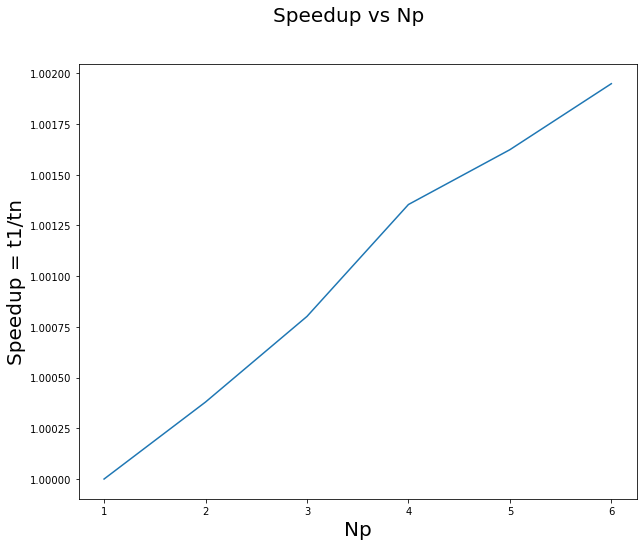

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

speedup = time_arr[0] / np.array(time_arr)
num_of_processes = range(1, 7)

plt.figure(figsize=(10, 8))
plt.plot(num_of_processes, speedup)
plt.xticks(num_of_processes)
plt.xlabel('Np', fontsize = 20)
plt.ylabel('Speedup = t1/tn', fontsize = 20)
plt.suptitle('Speedup vs Np', fontsize = 20)

**Code for parallelization**

In [ ]:
%%writefile task_7_test.py

import numpy as np
import matplotlib.pyplot as plt
import argparse
from mpi4py import MPI

def f(x):
    return x**4

def g(x):
    return x**5/5


def integrate(f, limits=(-3, 3), num_steps=10000000):
    steps = np.linspace(limits[0], limits[1], num=num_steps, endpoint=True)
    step_size = (limits[1] - limits[0]) / num_steps
    func_values = [f(x) for x in steps]
    result = (sum(func_values) * 2 - func_values[0] - func_values[1]) * 0.5 * step_size
    return result


def main(parallel=False):
    if parallel:
        comm = MPI.COMM_WORLD
        rank = comm.Get_rank()
        size = comm.Get_size()
        print('size ', size)
        all_nodes = np.linspace(-3, 3, num=size + 1)
        
        S_d = integrate(f, limits=all_nodes[rank:rank+2], num_steps=10000000)
        comm.Barrier()

        S_d = comm.gather(S_d, root=0)

        if rank == 0:
#             print(sum(S_d))
            return sum(S_d)
    else:
        S_d = integrate(f, limits=(-3, 3), num_steps=100000000)
#         print(S_d)
        return S_d
        
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser("Task 7")
    parser.add_argument("-parallel",  help="0 - not parallel, 1 - parallel", type=bool)
    args = parser.parse_args()
    main(args.parallel)

Overwriting task_7_test.py
